##  Movielens 영화 추천 시스템 





### MovieLens 1M Dataset
- ratings.dat
    - 6,040 MovieLens users
    - 3,900 movies 
    - 1,000,209 anonymous ratings : 평점(1~5)

- movies.dat
 - 영화 제목
 - 영화 장르

In [1]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/project/exp14_RecommenderSystem/data2/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### MovieLens EDA 및 전처리

In [2]:
ratings.shape

(1000209, 4)

In [3]:
ratings['ratings'].unique()

array([5, 3, 4, 2, 1])

In [4]:
ratings['user_id'].unique(), len(ratings['user_id'].unique())

(array([   1,    2,    3, ..., 6038, 6039, 6040]), 6040)

In [5]:
ratings['movie_id'].unique(), len(ratings['movie_id'].unique())

(array([1193,  661,  914, ..., 2845, 3607, 2909]), 3706)

6040명의 유저별, 3706개 영화에 대한 1,000,209건의 평점 정보(1점~5점)가 들어있다. 

ratings.dat 파일에는 영화제목에 관한 정보가 없어 추가가 필요하다. movies.dat 파일에서 읽어 merge해주겠다.

In [6]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/project/exp14_RecommenderSystem/data2/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


영화의 title 정보를 merge하기전에 검색을 쉽게하게위해 소문자로 바꾸겠다. 
- 영화 출시연도정보를 제외할 경우 다른해에 출시된 영화인데 동일한 제목의 영화로 인식되므로 삭제하지 않았다.

In [7]:
movies['title'] = movies['title'].str.lower() # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
#movies['title'] =movies['title'].str[:-6] # 고유 영화정보가 3883-> 3841건으로 줄어듬.
movies.head()

,movie_id,title,genre
0,1,toy story (1995),Animation|Children's|Comedy
1,2,jumanji (1995),Adventure|Children's|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama
4,5,father of the bride part ii (1995),Comedy


In [8]:
ratings = pd.merge(ratings, movies[['title', 'movie_id']], on='movie_id', how='left')
ratings.tail()

,user_id,movie_id,ratings,timestamp,title
1000204,6040,1091,1,956716541,weekend at bernie's (1989)
1000205,6040,1094,5,956704887,"crying game, the (1992)"
1000206,6040,562,5,956704746,welcome to the dollhouse (1995)
1000207,6040,1096,4,956715648,sophie's choice (1982)
1000208,6040,1097,4,956715569,e.t. the extra-terrestrial (1982)


<AxesSubplot:>

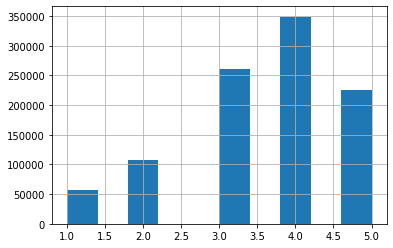

In [9]:
ratings['ratings'].hist()

많은경우 3점이상의 점수를 주고 있고 2,1점을 주는 경우도 적지 않게 나타나고 있다. **본 프로젝트에서는 명시적 평가정보인 평점을 재생횟수로 변경하여 암묵적 평가정보로 활용해보겠다. 그리고 암묵적 데이터의 해석시 한번이라도 들었다면 선호한다고 할 수 있으므로 평점이 1,2점인 경우의 데이터를 제외하였다.**
- 재생횟수(평점) 데이터 제외 
- 컬럼명 변경 : ratings -> counts
- 쓰지않는 컬럼 삭제 : timestamp

In [10]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [11]:
len(ratings['user_id'].unique()), len(ratings['title'].unique())

(6039, 3628)

83.63% 의 데이터가 남았고, 사용자가 기존보다 1명으며, 영화데이터가 78개가 삭제되었다

In [12]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [13]:
#사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'movie_id', 'counts', 'title']
ratings = ratings[using_cols]
ratings.head(1)

,user_id,movie_id,counts,title
0,1,1193,5,one flew over the cuckoo's nest (1975)


In [14]:
#인기 많은 영화(재생횟수가 많은 영화) 상위 30개
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_top30= movie_count.sort_values(ascending=False).head(30)
movie_top30_info = pd.merge(movie_top30, movies, left_on='movie_id', right_on='movie_id', how='inner')
movie_top30_info

,movie_id,user_id,title,genre
0,2858,3211,american beauty (1999),Comedy|Drama
1,260,2910,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,1196,2885,star wars: episode v - the empire strikes back...,Action|Adventure|Drama|Sci-Fi|War
3,1210,2716,star wars: episode vi - return of the jedi (1983),Action|Adventure|Romance|Sci-Fi|War
4,2028,2561,saving private ryan (1998),Action|Drama|War
5,589,2509,terminator 2: judgment day (1991),Action|Sci-Fi|Thriller
6,593,2498,"silence of the lambs, the (1991)",Drama|Thriller
7,1198,2473,raiders of the lost ark (1981),Action|Adventure
8,1270,2460,back to the future (1985),Comedy|Sci-Fi
9,2571,2434,"matrix, the (1999)",Action|Sci-Fi|Thriller


유저들에게 American Beauty, Star Wars 시리즈 등이 가장 많이 선호되는 영화로 나왔다.


In [15]:
# 유저별 몇 개의 영화를 보았는지 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

사용자별로 평균 138개의 영화를 보았고 중앙값은 96개이다.

### 내가 선호하는 영화를 5가지 골라서 ratings에 추가

좋아하는 영화 5가지를 추가해보자. (상위 top 200을 참고하여 추가하였다)

- 2571 : Matrix, the (1977)
- 1270	Back to the Future (1985)
- 1721 : Titanic (1997)
- 588 :	Aladdin (1992)
- 1 : Toy Story (1995)	

In [16]:
my_data = [(6041, 2571, 5, 'matrix, the (1999)'),
           (6041, 1270, 4, 'back to the future (1985)'),
           (6041, 1721, 5, 'titanic (1997)'),
           (6041, 588, 5, 'aladdin (1992)'),
           (6041, 1, 4, 'toy story (1995)') ]

df_my_data = pd.DataFrame(my_data, columns = ['user_id' , 'movie_id', 'counts', 'title'])
df_my_data

,user_id,movie_id,counts,title
0,6041,2571,5,"matrix, the (1999)"
1,6041,1270,4,back to the future (1985)
2,6041,1721,5,titanic (1997)
3,6041,588,5,aladdin (1992)
4,6041,1,4,toy story (1995)


In [17]:
ratings=ratings.append(df_my_data,ignore_index=True)
ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,title
836473,6040,1090,3,platoon (1986)
836474,6040,1094,5,"crying game, the (1992)"
836475,6040,562,5,welcome to the dollhouse (1995)
836476,6040,1096,4,sophie's choice (1982)
836477,6040,1097,4,e.t. the extra-terrestrial (1982)
836478,6041,2571,5,"matrix, the (1999)"
836479,6041,1270,4,back to the future (1985)
836480,6041,1721,5,titanic (1997)
836481,6041,588,5,aladdin (1992)
836482,6041,1,4,toy story (1995)


In [19]:
ratings['user_id'].nunique(), ratings['title'].nunique()

(6040, 3628)

6040명의 user와, 3628개의 movie 데이터를 관리하기 쉽도록 각각 인덱싱작업을 해준다. 

In [20]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings.user_id.unique()
movie_unique = ratings.title.unique()

# 유저, 영화 데이터에 indexing 
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}
len(user_to_idx), len(movie_to_idx)

(6040, 3628)

In [21]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx[6041])    #마지막에 추가한 user_id 6041에 대해 마지막인덱스로 6039가 나왔다. (기존에 6039명이 있었음.)
print(movie_to_idx['aladdin (1992)'])

6039
33


ratings dataFrame안의 user_id, movie_id정보를 위에서 생성한 인덱스 값으로 변경하겠다.

In [22]:
# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

user_id column indexing OK!!


In [23]:
# movie_to_idx.get을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('title column indexing OK!!')
    ratings['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

title column indexing OK!!


In [24]:
ratings.head()

,user_id,movie_id,counts,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4


In [25]:
ratings.tail()

,user_id,movie_id,counts,title
836478,6039,2571,5,124
836479,6039,1270,4,22
836480,6039,1721,5,27
836481,6039,588,5,33
836482,6039,1,4,40


---
### CSR matrix

평가행렬의 용량을 줄여 CSR(Compressed Sparse Row) Matrix로 표현해보겠다.


In [26]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

num_user, num_movie 

(6040, 3628)

In [27]:
csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

### 모델 학습

In [28]:
from implicit.als import AlternatingLeastSquares
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [29]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

### 내가 선호하는 영화와 그 외의 영화에 대한 나의 선호도

마지막에 추가한 user_id [6041], 영화 titanic (1997)에 대한 벡터값들을 확인해보자

In [30]:
last_user, last_movie = user_to_idx[6041], movie_to_idx['titanic (1997)']
last_user_vector, last_movie_vector = als_model.user_factors[last_user], als_model.item_factors[last_movie]

In [31]:
last_user_vector

array([ 0.24484397,  0.46249685,  1.1468915 , -0.29134485,  1.1742817 ,
        0.03438601, -0.1972549 , -0.07161164,  0.6185903 , -0.35005775,
       -0.38343674,  0.30315423,  0.7004424 , -0.20887037, -0.3909374 ,
       -0.46960068,  0.02499114, -1.0345329 ,  0.03395557,  0.5584285 ,
        0.11065578, -0.07267834,  0.01613028, -0.82419544, -0.21520334,
        0.5606965 ,  0.6962814 ,  0.33633432, -0.06738675,  0.04557437,
        0.8387089 , -0.48120478,  0.71796805, -0.20671532, -0.05931826,
        0.81947905,  0.6903318 ,  0.39598072, -0.7235702 ,  0.39808714,
        0.12558448,  0.84872055,  0.05605939, -0.59351134, -0.5132527 ,
       -0.07196011, -0.0809556 , -0.39677054, -0.13564119, -0.0426334 ,
        0.38894355, -0.29168135,  0.60409606,  0.6589619 ,  0.2966559 ,
        0.19747998, -0.28901032,  0.3676154 ,  0.09649532, -1.1960807 ,
       -0.33140612,  0.70290196, -0.31153178, -0.23877503,  0.31911436,
        0.11632042,  0.30128935,  0.26464808, -0.33675924, -0.10

In [32]:
last_movie_vector

array([-0.00511587,  0.00359681,  0.01735852,  0.02585074,  0.01750193,
       -0.00813538, -0.00460418, -0.01585675,  0.02826433,  0.00443425,
       -0.00524436,  0.00372854,  0.02653545,  0.03402574,  0.01427155,
       -0.02261803,  0.02559358, -0.00858785,  0.01151203,  0.04279863,
        0.01359248,  0.004963  , -0.01246416,  0.0038523 , -0.0115181 ,
        0.01445648, -0.02124107,  0.03110626, -0.03498765,  0.02130003,
        0.01974922, -0.02370538,  0.06068388, -0.01026758, -0.04149495,
        0.00799552,  0.02562861,  0.02159866, -0.01246288, -0.00049357,
        0.04133328,  0.0411631 , -0.01441712, -0.02307348,  0.01061425,
        0.01346766,  0.02231609,  0.00785527, -0.01916212, -0.0071184 ,
        0.02426795, -0.02916369, -0.00902927,  0.02421284,  0.02317657,
        0.00593532,  0.02108337,  0.02145636,  0.02688476, -0.01697322,
        0.00880989,  0.03293643, -0.01172875, -0.02505477,  0.00930512,
       -0.00387406,  0.0089567 , -0.00260393,  0.00721485, -0.00

In [33]:
# last_user_vector과 last_movie_vector를 내적하는 코드
np.dot(last_user_vector, last_movie_vector)

0.5786633

0.57점이 나왔다. 0.5 이상의 값이므로 약간 선호하는 것으로 판단할수 있겠다.

user_id [6041] 가 재생해보지 않은 영화로 sophie's choice (1982)에 대한 벡터값도 확인해보자  

In [34]:
last_user, last_movie = user_to_idx[6041], movie_to_idx['crying game, the (1992)']
last_user_vector, last_movie_vector = als_model.user_factors[last_user], als_model.item_factors[last_movie]
# last_user_vector과 last_movie_vector를 내적하는 코드
np.dot(last_user_vector, last_movie_vector)

0.012965114

0.01 로 아주 낮은 값이 나왔다. 짧은 훈련으로 선호도를 잘파악하고있는 것 같다.

### 내가 좋아하는 영화와 비슷한 영화 추천

- similar_items : 비슷한 취향의 영화 추천됨.

In [35]:
favorite_movie = 'aladdin (1992)' # 영화 Titanic
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=10) #top 10
similar_movie

[(33, 0.9999999),
 (10, 0.85068816),
 (330, 0.782581),
 (40, 0.5809658),
 (191, 0.5730937),
 (35, 0.5703993),
 (32, 0.5422972),
 (34, 0.54016155),
 (329, 0.5137606),
 (16, 0.5136503)]

유사도가 높은 상위 10개의 영화 인덱스가 반환되었다. 인덱스를 영화제목으로 다시 맴핑시켜서 출력해보자.

In [36]:
#movie_to_idx 를 뒤집어, index로부터  영화 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['aladdin (1992)',
 'beauty and the beast (1991)',
 'lion king, the (1994)',
 'toy story (1995)',
 'little mermaid, the (1989)',
 'hunchback of notre dame, the (1996)',
 'hercules (1997)',
 'mulan (1998)',
 'anastasia (1997)',
 'tarzan (1999)']

유사도가 비슷한 애니메이션 장르의 영화들이 추천되었다.

In [38]:
def get_similar_movie(movie_name: str, n_rank=10):
    movie_id = movie_to_idx[movie_name]
    similar_movie= als_model.similar_items(movie_id, N=n_rank)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [39]:
get_similar_movie('matrix, the (1999)', 5)

['matrix, the (1999)',
 'terminator 2: judgment day (1991)',
 'total recall (1990)',
 'fugitive, the (1993)',
 'terminator, the (1984)']

매트릭스에 대해서는 SF 영화들이 추천되었다. 

### 내가 가장 좋아할 만한 영화 추천

In [42]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=10, filter_already_liked_items=True)
movie_recommended

[(50, 0.42061862),
 (10, 0.3992937),
 (330, 0.3887612),
 (92, 0.38033873),
 (26, 0.34800157),
 (322, 0.3153975),
 (44, 0.28108203),
 (154, 0.2779503),
 (117, 0.26549453),
 (126, 0.26437065)]

In [43]:
[idx_to_movie[i[0]] for i in movie_recommended]

['toy story 2 (1999)',
 'beauty and the beast (1991)',
 'lion king, the (1994)',
 'terminator 2: judgment day (1991)',
 'e.t. the extra-terrestrial (1982)',
 'babe (1995)',
 'star wars: episode iv - a new hope (1977)',
 'as good as it gets (1997)',
 'star wars: episode v - the empire strikes back (1980)',
 'shakespeare in love (1998)']

toystory2가 추천되었다. explain함수를 이용해 나의 데이터가 이추천에 기여한 정도를 확인해보자.

In [44]:
toystory2 = movie_to_idx['toy story 2 (1999)']
explain = als_model.explain(user, csr_data, itemid=toystory2)
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('toy story (1995)', 0.35551162835199007),
 ('aladdin (1992)', 0.11322711914832724),
 ('back to the future (1985)', 0.010992513281940756),
 ('matrix, the (1999)', -0.024051996735718447),
 ('titanic (1997)', -0.04329900055251397)]